In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.metrics import f1_score
from IPython.display import display, HTML
from tensorflow_decision_forests import model_plotter
import warnings
warnings.filterwarnings('ignore')


In [3]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

dataset_df = pd.read_csv('train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


In [4]:
labels = pd.read_csv('train_labels.csv')

labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [5]:
labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


<Axes: xlabel='correct'>

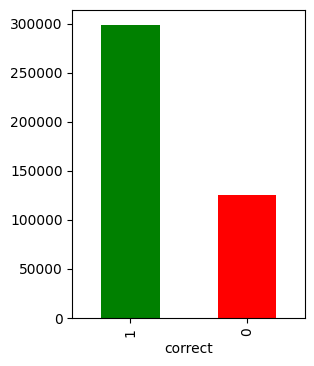

In [6]:
plt.figure(figsize=(3, 4))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['g', 'r'])

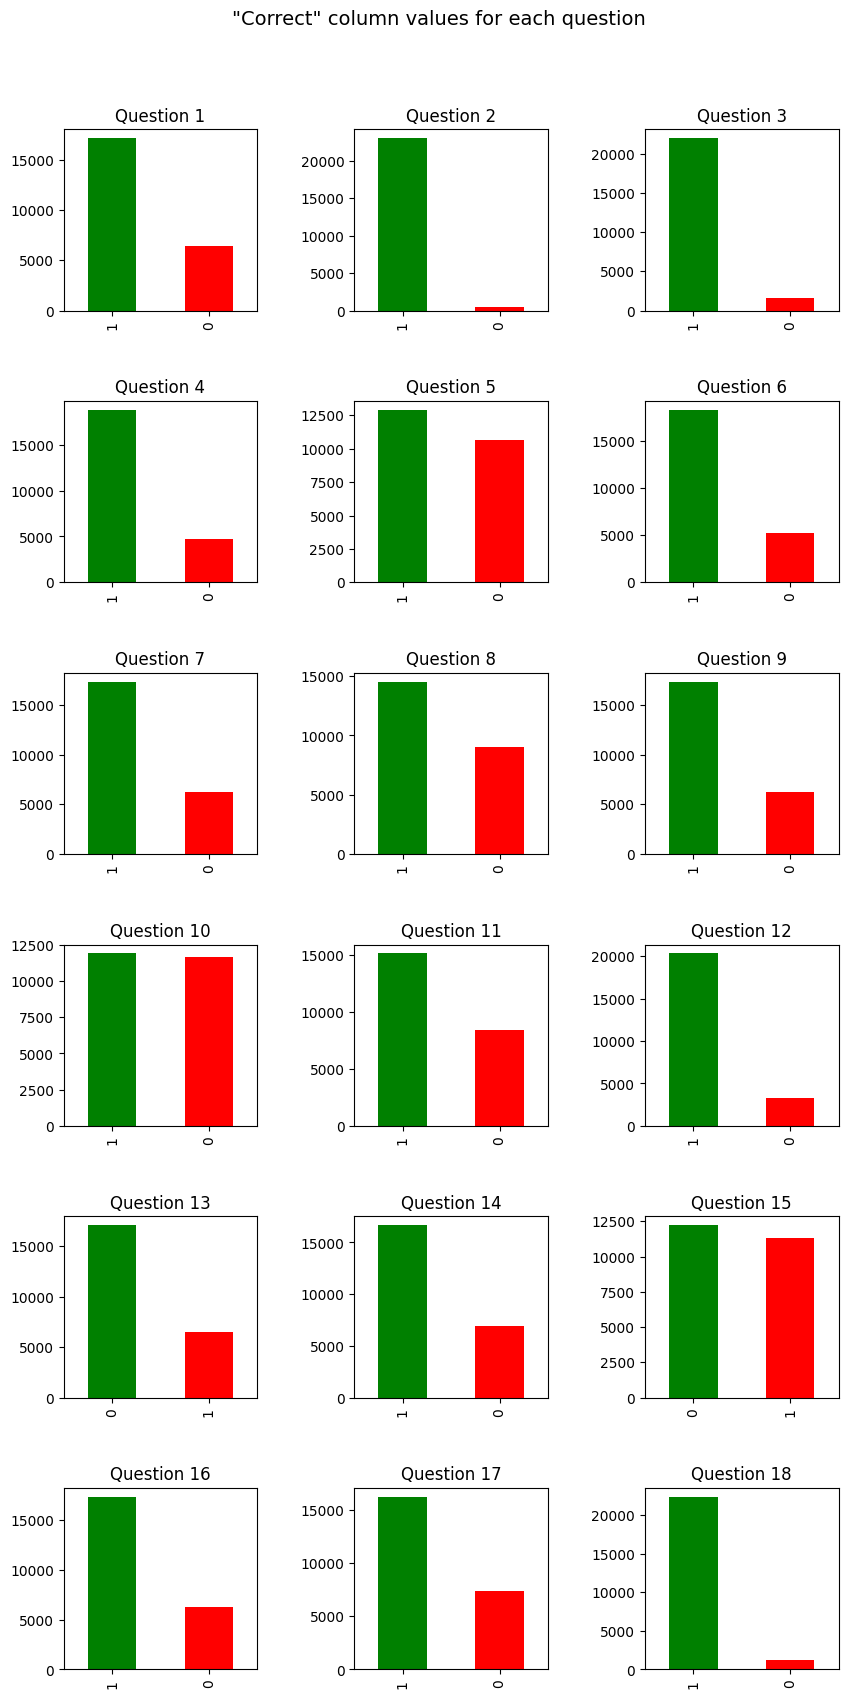

In [7]:
plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(6, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['g', 'r'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("")

In [31]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

In [34]:
def feature(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [35]:
dataset_df = feature(dataset_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

/tmp/ipykernel_9479/2294211538.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')


KeyError: 'Column not found: event_name'

In [30]:
# Display the first 5 examples
dataset_df.head(5)

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044861,2389.500000,49246.539458,1.230975,-1.000000,399.296051,129.292404,214.871002,104.082741,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347168,...,379.301025,899.925903,126666.129584,2.358652,-1.000000,622.061401,230.370880,240.280212,99.067863,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784912,969.333313,80175.676658,2.096919,-1.000000,357.227692,137.409470,203.268555,120.255455,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045959,...,370.723083,1378.750000,67372.714092,1.232616,0.000000,445.980042,156.186249,252.554703,121.062927,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762283,...,387.930084,720.384949,777382.529186,1.825923,0.863075,529.575684,234.279587,259.288849,133.345688,1990.705518


In [14]:
dataset_df.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
count,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,...,70686.000000,7.068600e+04,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04
mean,10.390021,3.885324,40.468650,10.268908,23.838412,2.811806e+06,9.311221,1.439995,-33.454849,-92.222832,...,379.749146,4.119625e+03,9.322398e+05,1.916549,0.038805,468.689087,183.186310,240.795441,124.016609,1.322598e+04
std,0.832923,0.799293,13.020929,2.928351,8.989095,2.289877e+07,6.523788,2.350494,80.784378,69.349052,...,36.971046,1.394260e+05,1.206491e+07,0.492239,0.785170,106.991646,48.884987,28.709135,15.844603,4.868272e+05
min,7.000000,3.000000,18.000000,5.000000,8.000000,4.591262e+02,0.923372,-1.000000,-461.440765,-409.231293,...,177.051849,-1.000000e+00,2.337003e+02,0.684670,-1.000000,261.425415,90.098534,109.415466,68.257408,-1.000000e+00
25%,10.000000,3.000000,25.000000,7.000000,15.000000,1.642777e+05,2.051613,-1.000000,-90.615677,-151.717484,...,358.117455,9.709706e+02,8.240024e+04,1.295298,-1.000000,381.066231,143.588600,222.569736,113.994305,1.368802e+03
50%,11.000000,4.000000,43.000000,11.000000,23.000000,5.882137e+05,8.140526,1.000000,-20.255625,-71.538723,...,377.843857,1.427761e+03,1.440869e+05,2.099711,0.000000,431.901352,162.941971,238.383835,122.388962,2.041432e+03
75%,11.000000,4.000000,51.000000,12.000000,32.000000,1.351434e+06,17.592593,4.000000,23.220109,-38.693486,...,397.018394,2.158794e+03,2.240529e+05,2.316163,0.735893,585.347595,233.385265,255.083351,132.067429,3.105588e+03
max,11.000000,6.000000,81.000000,17.000000,48.000000,1.191886e+09,20.222101,6.000000,328.096100,160.347977,...,986.192993,2.772298e+07,9.946229e+08,3.580235,2.715695,817.257141,349.049316,612.958618,331.833801,7.837739e+07


/tmp/ipykernel_9479/249453236.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, data in dataset_df.groupby('level_group'):


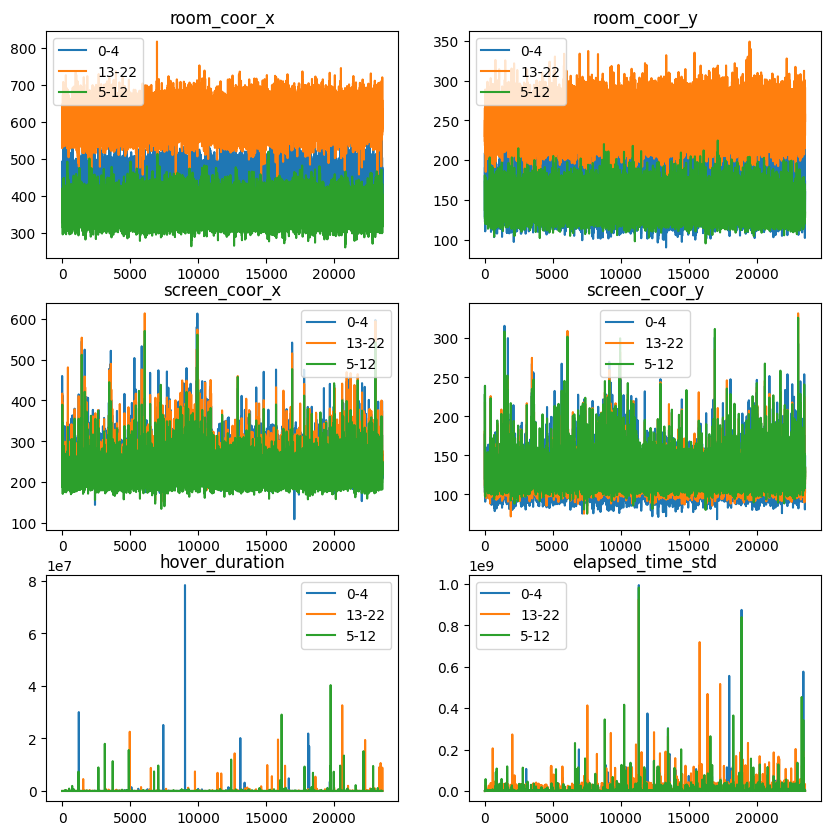

In [15]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))

for name, data in dataset_df.groupby('level_group'):
    axis[0, 0].plot(range(1, len(data['room_coor_x_std'])+1), data['room_coor_x_std'], label=name)
    axis[0, 1].plot(range(1, len(data['room_coor_y_std'])+1), data['room_coor_y_std'], label=name)
    axis[1, 0].plot(range(1, len(data['screen_coor_x_std'])+1), data['screen_coor_x_std'], label=name)
    axis[1, 1].plot(range(1, len(data['screen_coor_y_std'])+1), data['screen_coor_y_std'], label=name)
    axis[2, 0].plot(range(1, len(data['hover_duration'])+1), data['hover_duration_std'], label=name)
    axis[2, 1].plot(range(1, len(data['elapsed_time_std'])+1), data['elapsed_time_std'], label=name)
    

axis[0, 0].set_title('room_coor_x')
axis[0, 1].set_title('room_coor_y')
axis[1, 0].set_title('screen_coor_x')
axis[1, 1].set_title('screen_coor_y')
axis[2, 0].set_title('hover_duration')
axis[2, 1].set_title('elapsed_time_std')

for i in range(3):
    axis[i, 0].legend()
    axis[i, 1].legend()

plt.show()

In [16]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset_df.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

56547 examples in training, 14139 examples in testing.


In [17]:
# Fetch the unique list of user sessions in the validation dataset. 
VALID_USER_LIST = valid_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users
# in the validation set.
# The dataframe's index column is the user `session_id`s. 
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

In [53]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    # Converting to tensorflow
    # Dropping level group as no longer needed.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    # Using gradient boosted trees model
    gbtm = tfdf.keras.GradientBoostedTreesModel(verbose=0)
    gbtm.compile(metrics=["accuracy"])

    # Train the model.
    gbtm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = evaluation["accuracy"]         

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten() 

### q_no 1 grp 0-4


2024-12-11 09:40:23.051799: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:23.051940: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:23.051969: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931623.464575    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931623.464611    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931623.464622    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 11ms/step
### q_no 2 grp 0-4


2024-12-11 09:40:24.577885: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:24.577988: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:24.578008: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931624.995259    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931624.995290    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931624.995299    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 9ms/step
### q_no 3 grp 0-4


2024-12-11 09:40:25.749538: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:25.749593: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:25.749615: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931626.117624    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931626.117662    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931626.117672    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 9ms/step
### q_no 4 grp 5-12


2024-12-11 09:40:26.920521: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:26.920618: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:26.920640: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931627.309928    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931627.309961    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931627.309971    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 9ms/step
### q_no 5 grp 5-12


2024-12-11 09:40:28.668154: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:28.668210: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:28.668231: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931629.061214    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931629.061254    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931629.061277    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 10ms/step
### q_no 6 grp 5-12


2024-12-11 09:40:30.041132: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:30.041194: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:30.041214: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931630.424317    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931630.424372    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931630.424389    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 9ms/step
### q_no 7 grp 5-12


2024-12-11 09:40:31.578241: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:31.578299: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:31.578319: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931631.957246    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931631.957295    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931631.957308    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 9ms/step
### q_no 8 grp 5-12


2024-12-11 09:40:33.386445: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:33.386508: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:33.386527: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931633.839394    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931633.839444    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931633.839455    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 9ms/step
### q_no 9 grp 5-12


2024-12-11 09:40:34.608602: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:34.608662: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:34.608681: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931634.978605    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931634.978649    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931634.978663    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 10ms/step
### q_no 10 grp 5-12


2024-12-11 09:40:35.894396: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:35.894454: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:35.894475: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931636.311083    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931636.311129    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931636.311143    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 11ms/step
### q_no 11 grp 5-12


2024-12-11 09:40:37.436969: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:37.437027: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:37.437047: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931637.832097    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931637.832135    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931637.832150    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 10ms/step
### q_no 12 grp 5-12


2024-12-11 09:40:38.793031: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:38.793088: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:38.793108: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931639.162043    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931639.162082    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931639.162091    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 9ms/step
### q_no 13 grp 5-12


2024-12-11 09:40:40.005782: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:40.005838: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:40.005858: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931640.385543    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931640.385598    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931640.385613    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 10ms/step
### q_no 14 grp 13-22


2024-12-11 09:40:41.425100: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:41.425158: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:41.425178: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931641.809389    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931641.809428    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931641.809442    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 8ms/step
### q_no 15 grp 13-22


2024-12-11 09:40:42.808626: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:42.808686: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:42.808706: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931643.177182    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931643.177244    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931643.177262    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 10ms/step
### q_no 16 grp 13-22


2024-12-11 09:40:44.218889: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:44.218950: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:44.218971: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931644.579343    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931644.579379    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931644.579388    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 10ms/step
### q_no 17 grp 13-22


2024-12-11 09:40:45.328859: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:45.328916: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:45.328936: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931645.756846    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931645.756906    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931645.756925    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 11ms/step
### q_no 18 grp 13-22


2024-12-11 09:40:46.639213: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:46.639282: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-11 09:40:46.639302: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
I0000 00:00:1733931647.016491    9479 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1733931647.016528    9479 kernel.cc:783] Collect training examples
I0000 00:00:1733931647.016550    9479 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {


5/5 [==============================] - 0s 10ms/step


In [23]:
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.7286
question 2: accuracy 0.9743
question 3: accuracy 0.9351
question 4: accuracy 0.7957
question 5: accuracy 0.6319
question 6: accuracy 0.7885
question 7: accuracy 0.7456
question 8: accuracy 0.6355
question 9: accuracy 0.7632
question 10: accuracy 0.6109
question 11: accuracy 0.6522
question 12: accuracy 0.8695
question 13: accuracy 0.7218
question 14: accuracy 0.7337
question 15: accuracy 0.6166
question 16: accuracy 0.7486
question 17: accuracy 0.7027
question 18: accuracy 0.9510

Average accuracy 0.7558526065614488


In [24]:
#variable importance
inspector = models['0-4_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [50]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("room_fqid_nunique" (1; #16), 9.0),
 ("level" (1; #7), 5.0),
 ("name_nunique" (1; #9), 5.0),
 ("text_fqid_nunique" (1; #21), 5.0),
 ("hover_duration_std" (1; #6), 4.0),
 ("page" (1; #10), 4.0),
 ("screen_coor_x_std" (1; #18), 4.0),
 ("elapsed_time" (1; #1), 2.0),
 ("page_std" (1; #11), 2.0),
 ("room_coor_x" (1; #12), 2.0),
 ("event_name_nunique" (1; #3), 1.0),
 ("room_coor_y_std" (1; #15), 1.0)]

In [42]:
def plot_model(model, tree_idx=0, max_depth=3):
    # Generate HTML visualization of the model
    html = model_plotter.plot_model(model, tree_idx=tree_idx, max_depth=max_depth)
    # Display the HTML in the notebook
    display(HTML(html))

plot_model(models['0-4_1'], tree_idx=0, max_depth=3)

In [27]:
# Initialize the DataFrame for true labels
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST), 18)), index=VALID_USER_LIST)

# Populate the DataFrame with true labels
for i in range(18):
    tmp = labels.loc[labels.q == i + 1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

# Initialize variables for the best threshold and maximum F1 score
max_score = 0
best_threshold = 0

# Loop through threshold values from 0.4 to 0.8
for threshold in np.arange(0.4, 0.8, 0.01):
    # Flatten true and predicted values
    y_true = true_df.values.reshape((-1))
    y_pred = (prediction_df.values.reshape((-1)) > threshold).astype(int)
    
    # Calculate F1 score using sklearn
    f1_score_value = f1_score(y_true, y_pred, average='macro')
    
    # Update the best threshold and max_score
    if f1_score_value > max_score:
        max_score = f1_score_value
        best_threshold = threshold

print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.6300000000000002 	F1 score  0.6738222794127289
